In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


# Part of the training and accuracy check were taken from assigment-2

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

def check_accuracy_part(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
def train_part(model, optimizer, epochs=1):
    """
    Train a model on MNIST using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    best_acc = -1
    best_model = None
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(data_train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy_part(data_test_loader, model)
                if acc > best_acc:
                    best_acc = acc
                    best_model = model
                print()
    print('Best accuracy found', best_acc)
    return best_model


In [2]:
data_train = MNIST('./data/mnist',
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor()]))

data_test = MNIST('./data/mnist',
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                      transforms.Resize((32, 32)),
                      transforms.ToTensor()]))

data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True)
data_test_loader = DataLoader(data_test, batch_size=1024)

dtype = torch.float32

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print_every = 50
print('using device:', device)


# Lenet-5 architecture
model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    Flatten(),
    nn.Linear(5*5*16, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
)

#optimizer = optim.SGD(model.parameters(), lr=2e-2, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

best_model = train_part(model, optimizer, 4)

print(best_model)

using device: cuda
Iteration 0, loss = 2.3027
Checking accuracy on test set
Got 1032 / 10000 correct (10.32)

Iteration 50, loss = 0.4165
Checking accuracy on test set
Got 8942 / 10000 correct (89.42)

Iteration 100, loss = 0.1978
Checking accuracy on test set
Got 9389 / 10000 correct (93.89)

Iteration 150, loss = 0.1421
Checking accuracy on test set
Got 9555 / 10000 correct (95.55)

Iteration 200, loss = 0.1490
Checking accuracy on test set
Got 9654 / 10000 correct (96.54)

Iteration 0, loss = 0.1185
Checking accuracy on test set
Got 9663 / 10000 correct (96.63)

Iteration 50, loss = 0.0883
Checking accuracy on test set
Got 9722 / 10000 correct (97.22)

Iteration 100, loss = 0.0860
Checking accuracy on test set
Got 9745 / 10000 correct (97.45)

Iteration 150, loss = 0.0492
Checking accuracy on test set
Got 9789 / 10000 correct (97.89)

Iteration 200, loss = 0.0580
Checking accuracy on test set
Got 9775 / 10000 correct (97.75)

Iteration 0, loss = 0.0758
Checking accuracy on test set


w_0_weight_2d (6, 1, 5, 5)
w_3_weight_2d (16, 6, 5, 5)
w_7_weight_2d (120, 400)
w_9_weight_2d (84, 120)
w_11_weight_2d (10, 84)
torch.Size([1024, 10])
tensor([ 1.5575, -1.0157, -2.1311, -6.8397,  1.8811,  2.1535, 11.7107, -5.0137,
        -4.1270, -4.9690], device='cuda:0', grad_fn=<SelectBackward>) 
 prediction: tensor(6, device='cuda:0')


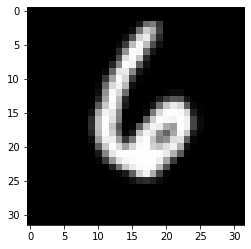

In [3]:
# weights header generator. This generates main.h

weights_file = open('main.h', 'w')

weights_file.write('typedef float data_t;\n\
\n\
typedef struct twoD\n\
{\n\
	uint32_t r;\n\
	uint32_t c;\n\
	uint32_t in_channel;\n\
    uint32_t channel;\n\
	data_t *data;\n\
	data_t *bias;\n\
} twoD_t;\n\n')

prev_shapes = None
prev_arr_name = None

for name, param in best_model.state_dict().items():
    arr = param.cpu().numpy();
    shape_of_params = arr.shape
    param_size =  len(arr.flatten())
    #print(name, 'param size:', param_size)
    underscore_arr_name = 'w_'+name.replace('.', '_')
    array_name  = underscore_arr_name + '[' + str(param_size) + ']=' 
    weights_file.write('const data_t '+array_name+'{')
    np.savetxt(weights_file, arr.flatten(), newline=',')
    weights_file.write('};\n\n')
    if len(shape_of_params) == 1:
        if len(prev_shapes) > 2:
            out_channel = prev_shapes[0]
            in_channel = prev_shapes[1]
        else:
            out_channel = 1
            in_channel = 1

        weights_file.write('const twoD_t '+prev_arr_name+'_2d = {\n\
                           .r ='+ str(prev_shapes[-1]) +',\n\
                           .c = '+str(prev_shapes[-2])+',\n\
                           .in_channel = '+str(in_channel)+',\n\
                           .channel = '+str(out_channel)+',\n\
                           .data = '+prev_arr_name+',\n\
                           .bias = '+underscore_arr_name+'\n\
                       };\n\n')
        print(prev_arr_name+'_2d', prev_shapes)
    prev_shapes = shape_of_params
    prev_arr_name = underscore_arr_name

    
class lenet5_partial(nn.Module):
    def __init__(self, original_model):
        super(lenet5_partial, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-6])
        
    def forward(self, x):
        x = self.features(x)
        return x

lenet_debug = lenet5_partial(best_model)


for i, (images, labels) in enumerate(data_test_loader):
    if i == 6:
        selected_in_batch = 108
        img = images[selected_in_batch].numpy()
        plt.imshow(img.reshape(32,32), cmap='gray', vmin=0, vmax=1)
        
        weights_file.write('const data_t test[32*32]={')
        np.savetxt(weights_file, images[selected_in_batch].flatten(), newline=',')
        weights_file.write('};\n')

        images = images.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        #output = lenet_debug(images)
        output = best_model(images)
        print(output.shape)
        _, preds = output.max(axis=1)
        #print(output[selected_in_batch, 0])
        print(output[selected_in_batch], '\n prediction:', preds[selected_in_batch])
        break

weights_file.close()